In [41]:
from util import *

In [42]:
import os
import numpy as np

In [43]:
import matplotlib.image as mpimg

In [44]:
from IPython.display import HTML

# NAMESPACE

In [45]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DATA_RPT_SLKH_CUST_PRODUCT_ALL'
    SEL_SAMPLE = 'SAMPLE1_SUB3'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [46]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DATA_RPT_SLKH_CUST_PRODUCT_ALL X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB3 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [47]:
NAMESPACE.init()

In [48]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [49]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [50]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [51]:
def default_func(x):
    return x

In [52]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [53]:
def logx(x):
    return np.log(x)

In [54]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [55]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [56]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [57]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [58]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DATA_RPT_SLKH_CUST_PRODUCT_ALL X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB3 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [59]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 494820


In [60]:
df

,PROCESS_DT,CUSTOMER_CDE,CUST_TYPE,CUST_STATUS,BH,IB,MB,PAY,TKTT,TK,...,SD_CREDIT,SD_PREPAID,PAYROLL,SD_PAYROLL,SD_SP_KHAC,OS_AMT_LCL,ACTUAL_AMT_LCL,LASTEST_TRANS_DT,REC_CREATE_DT,CUST_OPEN_DT
0,2024-01-07,12030062,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,2022-12-29,2024-01-08 07:24:40,2018-06-29
1,2024-01-07,1203237,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,NaT,2024-01-08 07:24:40,2009-08-08
2,2024-01-07,12032372,CN,HOAT DONG,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,NaN,NaN,0,0.000,0.000,2023-07-17,2024-01-08 07:24:40,2018-06-30
3,2024-01-07,12032399,CN,HOAT DONG,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,61179.000,2024-01-01,2024-01-08 07:24:40,2018-06-30
4,2024-01-07,12032426,CN,DONG BANG,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,NaN,NaN,1,0.000,0.000,2019-01-02,2024-01-08 07:24:40,2018-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494815,2024-01-07,16100962,CN,NGU DONG,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,0.000,NaT,2024-01-08 07:24:40,2021-09-26
494816,2024-01-07,16100989,CN,HOAT DONG,0.000,0.000,0.000,1.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,15520414.000,2024-01-06,2024-01-08 07:24:40,2021-09-26
494817,2024-01-07,1610101,DN,DONG BANG,NaN,0.000,0.000,NaN,0.000,0.000,...,0.000,NaN,0.000,0.000,0,0.000,0.000,NaT,2024-01-08 07:24:40,NaT
494818,2024-01-07,16101937,CN,HOAT DONG,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,55976.000,2024-01-01,2024-01-08 07:24:40,2021-09-27


In [61]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,PROCESS_DT,0.000,datetime64[ns],1,0.000,[2024-01-07T00:00:00.000000000]
1,CUSTOMER_CDE,0.000,object,494820,1.000,"[12030062, 1203237, 12032372]"
2,CUST_TYPE,0.000,object,2,0.000,"[CN, DN]"
3,CUST_STATUS,0.000,object,3,0.000,"[DONG BANG, HOAT DONG, NGU DONG]"
4,BH,0.374,float64,2,0.000,"[nan, 0.0, 1.0]"
5,IB,0.353,float64,2,0.000,"[nan, 0.0, 1.0]"
6,MB,0.353,float64,2,0.000,"[nan, 0.0, 1.0]"
7,PAY,0.374,float64,2,0.000,"[nan, 0.0, 1.0]"
8,TKTT,0.353,float64,2,0.000,"[nan, 0.0, 1.0]"
9,TK,0.353,float64,2,0.000,"[nan, 1.0, 0.0]"


In [62]:
df.describe()

,BH,IB,MB,PAY,TKTT,TK,VAY,DEBIT,MD,LC,...,SD_TTQT,CREDIT,PREPAID,SD_CREDIT,SD_PREPAID,PAYROLL,SD_PAYROLL,SD_SP_KHAC,OS_AMT_LCL,ACTUAL_AMT_LCL
count,309610.000,319902.000,319902.000,309610.000,319902.000,319902.000,319902.000,193097.000,10292.000,10292.000,...,10292.000,319902.000,309610.000,319902.000,309610.000,10292.000,10292.000,494820.000,494820.000,494820.000
mean,0.011,0.013,0.083,0.242,0.804,0.088,0.027,0.948,0.020,0.002,...,0.020,0.073,0.008,0.075,0.008,0.008,0.008,0.058,20831155.348,29638229.194
std,0.105,0.114,0.277,0.428,0.397,0.283,0.162,0.221,0.141,0.042,...,0.139,0.261,0.091,0.263,0.091,0.089,0.089,0.233,1379247873.641,642767210.274
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,140.000
75%,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,59044.250
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,673058324710.000,192049236115.000


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [63]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT',
        'BLOCK_INDEX', 'CUSTOMER_ID', 'SUB_SECTOR_CDE', 'SMS_PHONE', 'ACCT_ID', 'PROCESS_DT'
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
2,CUST_TYPE,0.000,object,2,0.000,"[CN, DN]"
3,CUST_STATUS,0.000,object,3,0.000,"[DONG BANG, HOAT DONG, NGU DONG]"
4,BH,0.374,float64,2,0.000,"[nan, 0.0, 1.0]"
5,IB,0.353,float64,2,0.000,"[nan, 0.0, 1.0]"
6,MB,0.353,float64,2,0.000,"[nan, 0.0, 1.0]"
7,PAY,0.374,float64,2,0.000,"[nan, 0.0, 1.0]"
8,TKTT,0.353,float64,2,0.000,"[nan, 0.0, 1.0]"
9,TK,0.353,float64,2,0.000,"[nan, 1.0, 0.0]"
10,VAY,0.353,float64,2,0.000,"[nan, 0.0, 1.0]"
11,DEBIT,0.610,float64,2,0.000,"[nan, 1.0, 0.0]"


CN    484528
DN     10292
Name: CUST_TYPE, dtype: int64

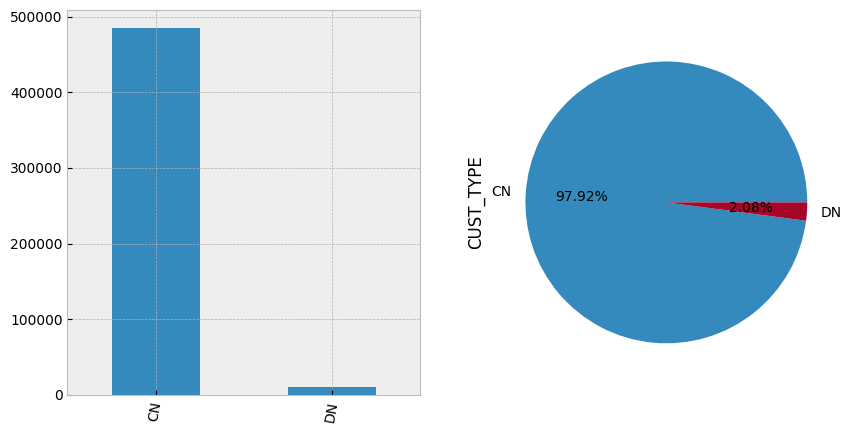

HOAT DONG    253843
DONG BANG    206036
NGU DONG      34941
Name: CUST_STATUS, dtype: int64

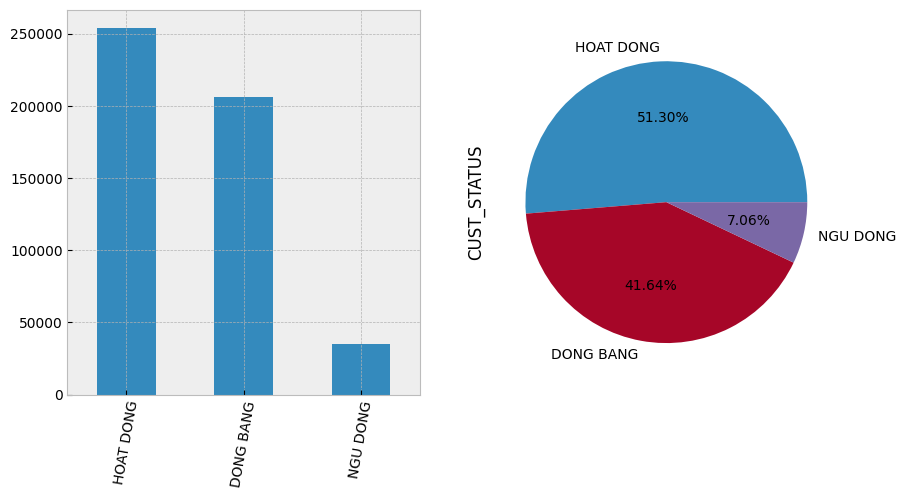

,default_func,remove_mode_value,logx
count,309610.000,3428.000,3428.000
count_pct_chg,100.000,-98.893,-98.893
mean,0.011,1.000,0.000
mean_pct_chg,100.000,8931.797,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


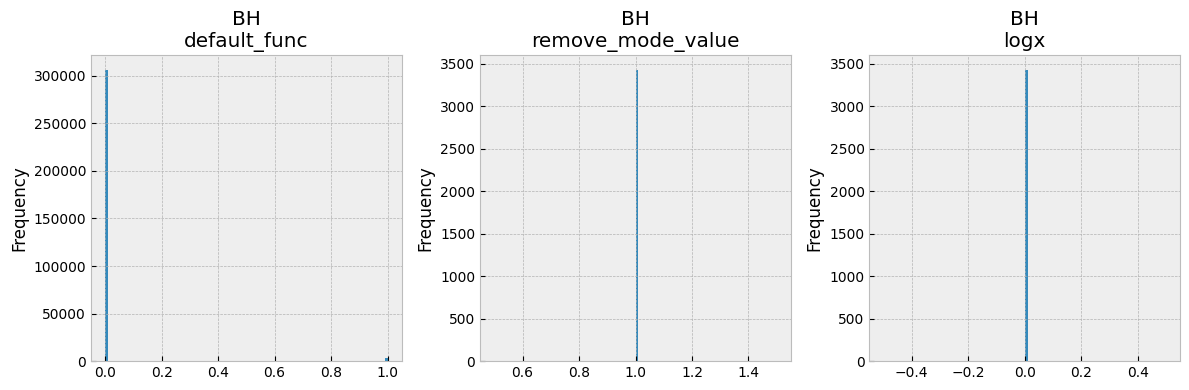

,default_func,remove_mode_value,logx
count,319902.000,4212.000,4212.000
count_pct_chg,100.000,-98.683,-98.683
mean,0.013,1.000,0.000
mean_pct_chg,100.000,7495.014,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


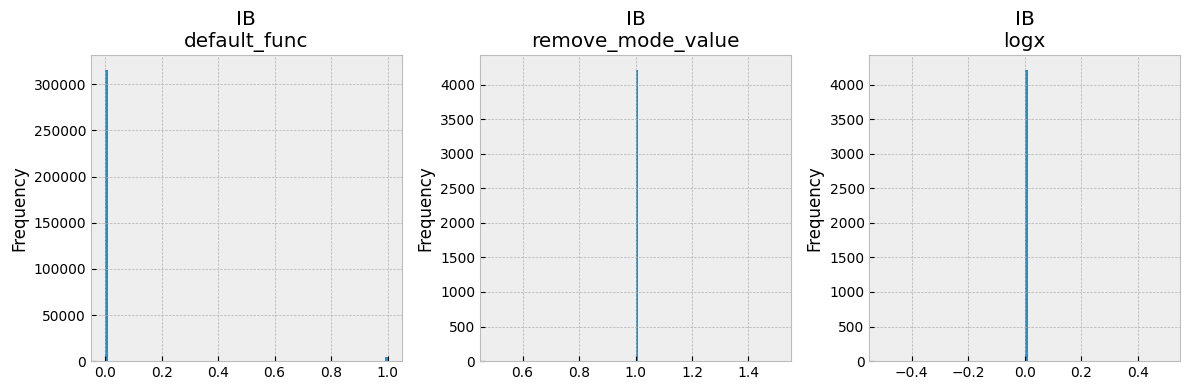

,default_func,remove_mode_value,logx
count,319902.000,26694.000,26694.000
count_pct_chg,100.000,-91.656,-91.656
mean,0.083,1.000,0.000
mean_pct_chg,100.000,1098.404,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


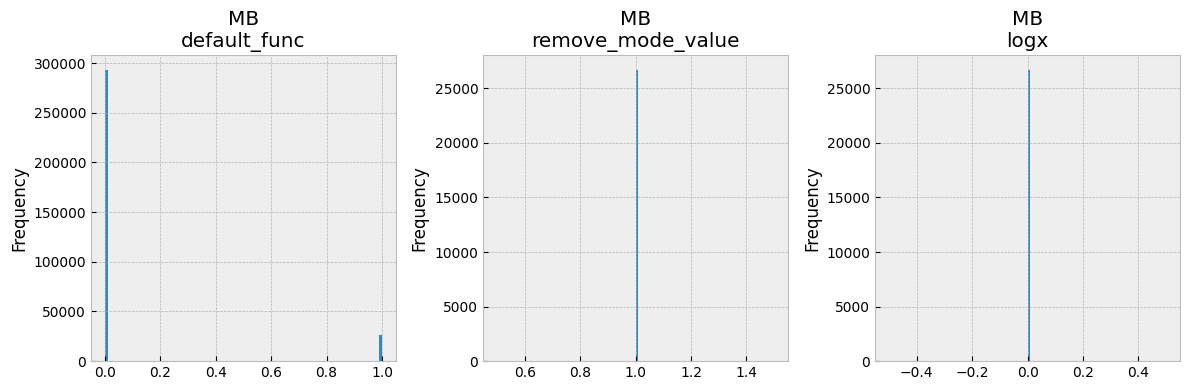

,default_func,remove_mode_value,logx
count,309610.000,74898.000,74898.000
count_pct_chg,100.000,-75.809,-75.809
mean,0.242,1.000,0.000
mean_pct_chg,100.000,313.376,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


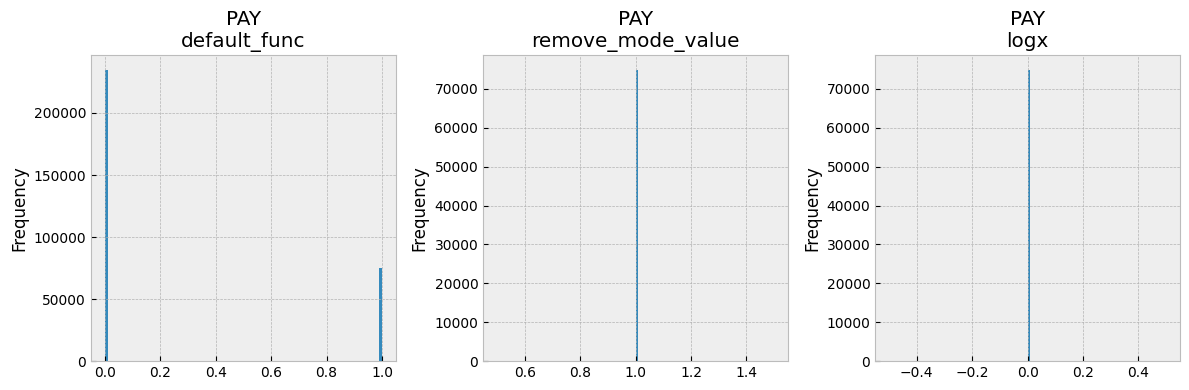

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,319902.000,62736.000,62736.000
count_pct_chg,100.000,-80.389,-80.389
mean,0.804,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


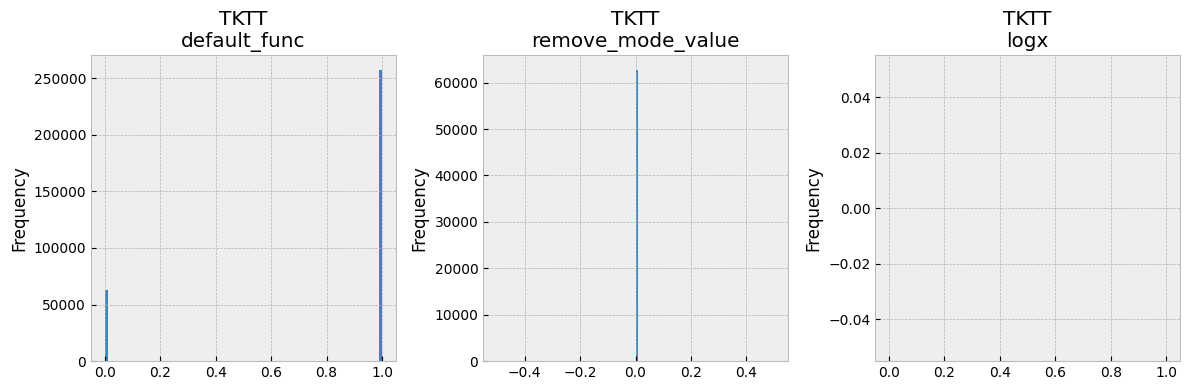

,default_func,remove_mode_value,logx
count,319902.000,28006.000,28006.000
count_pct_chg,100.000,-91.245,-91.245
mean,0.088,1.000,0.000
mean_pct_chg,100.000,1042.262,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


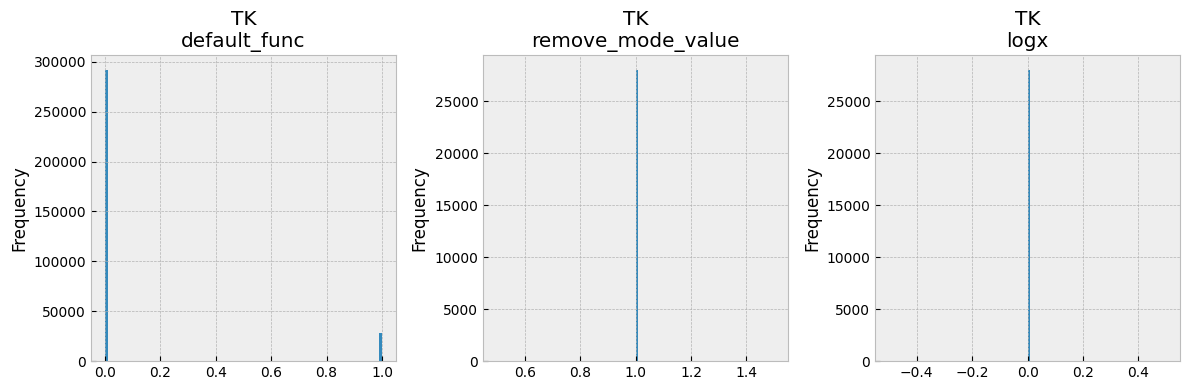

,default_func,remove_mode_value,logx
count,319902.000,8610.000,8610.000
count_pct_chg,100.000,-97.309,-97.309
mean,0.027,1.000,0.000
mean_pct_chg,100.000,3615.470,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


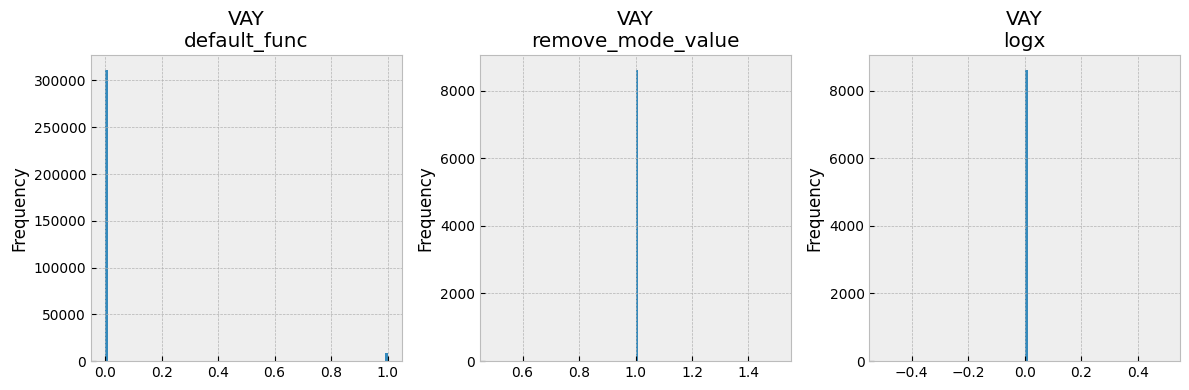

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,193097.000,9948.000,9948.000
count_pct_chg,100.000,-94.848,-94.848
mean,0.948,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


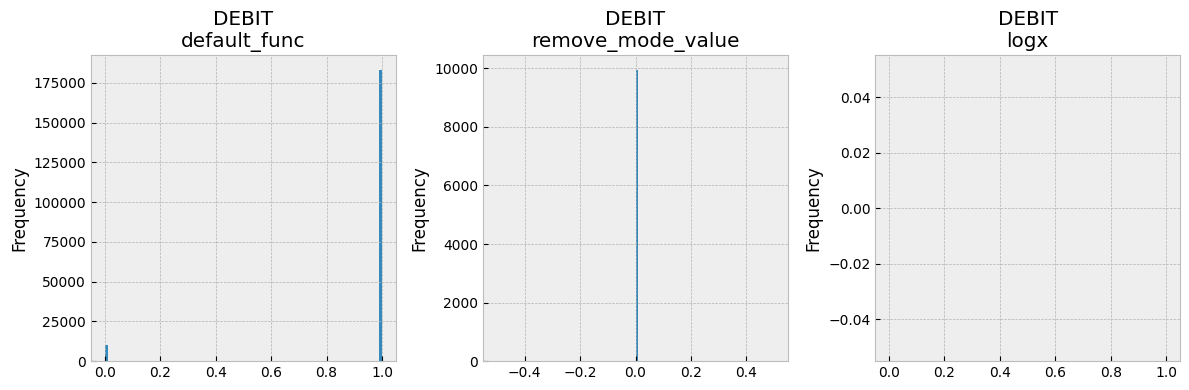

,default_func,remove_mode_value,logx
count,10292.000,210.000,210.000
count_pct_chg,100.000,-97.960,-97.960
mean,0.020,1.000,0.000
mean_pct_chg,100.000,4800.952,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


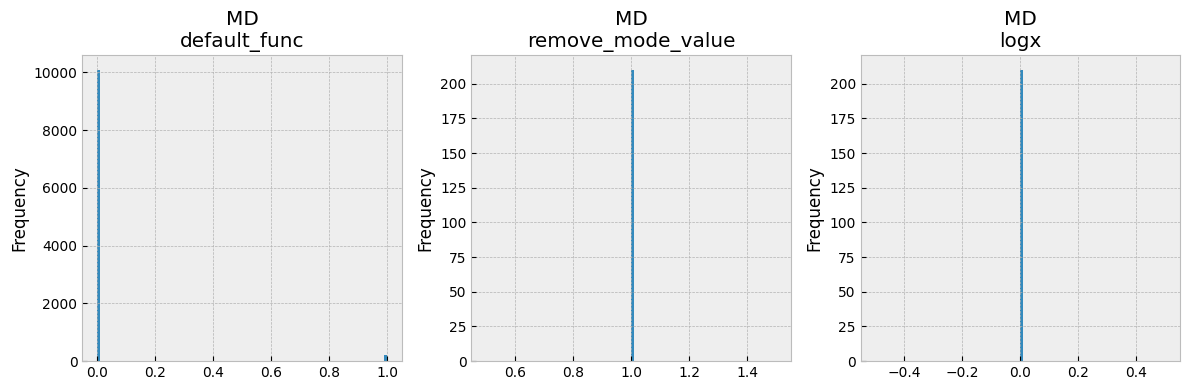

,default_func,remove_mode_value,logx
count,10292.000,18.000,18.000
count_pct_chg,100.000,-99.825,-99.825
mean,0.002,1.000,0.000
mean_pct_chg,100.000,57077.778,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


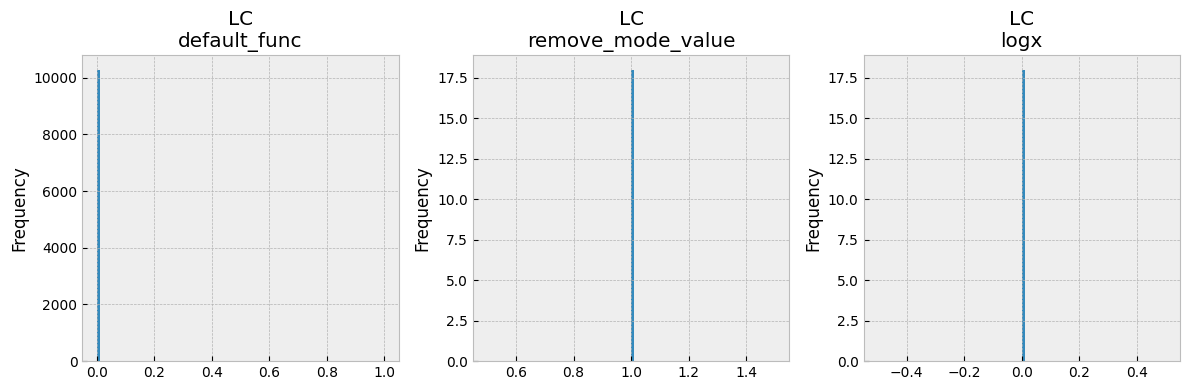

,default_func,remove_mode_value,logx
count,10292.000,217.000,217.000
count_pct_chg,100.000,-97.892,-97.892
mean,0.021,1.000,0.000
mean_pct_chg,100.000,4642.857,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


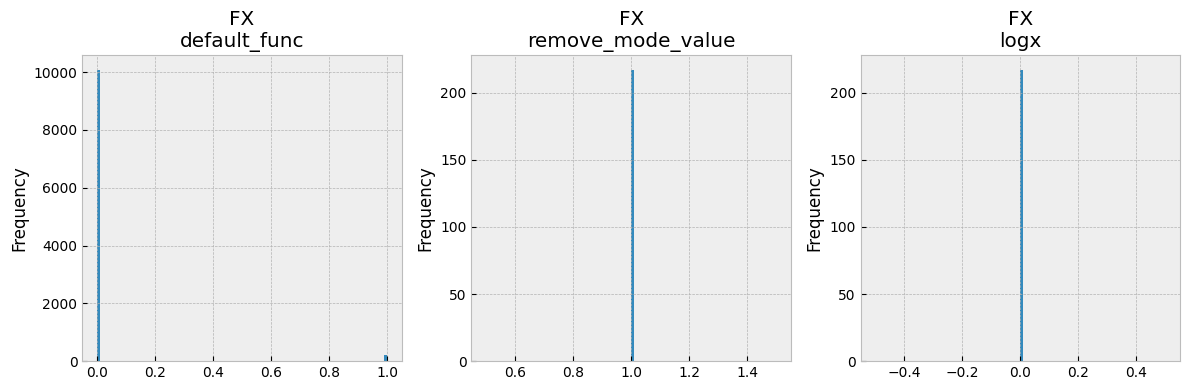

,default_func,remove_mode_value,logx
count,10292.000,204.000,204.000
count_pct_chg,100.000,-98.018,-98.018
mean,0.020,1.000,0.000
mean_pct_chg,100.000,4945.098,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


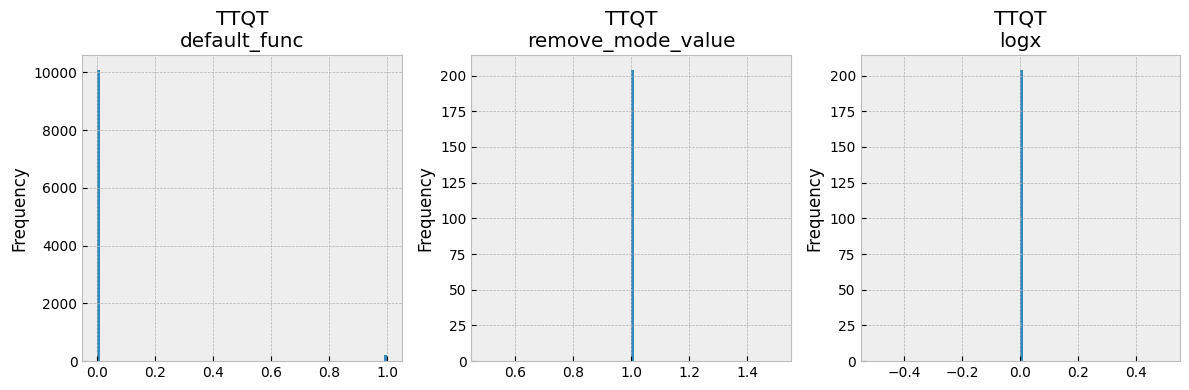

,default_func,remove_mode_value,logx
count,494820.000,28882.000,28882.000
count_pct_chg,100.000,-94.163,-94.163
mean,0.058,1.000,0.000
mean_pct_chg,100.000,1613.247,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


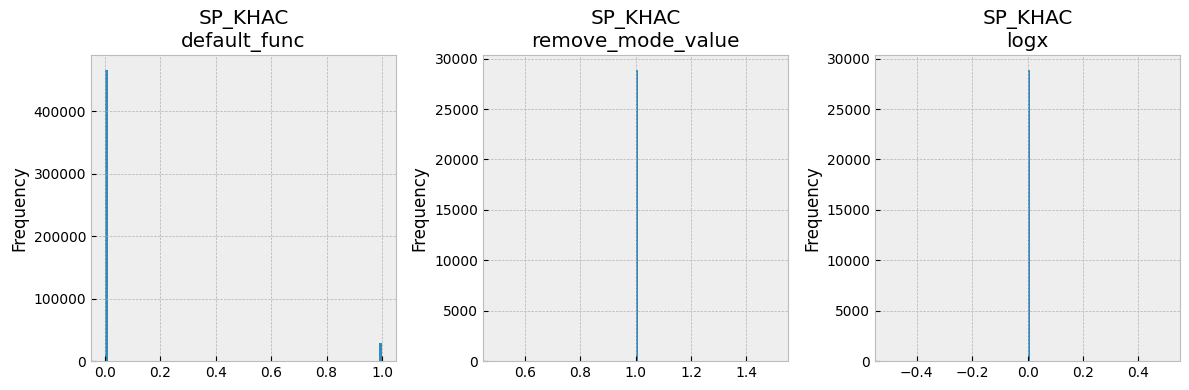

,default_func,remove_mode_value,logx
count,309610.000,3428.000,3428.000
count_pct_chg,100.000,-98.893,-98.893
mean,0.011,1.000,0.000
mean_pct_chg,100.000,8931.797,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


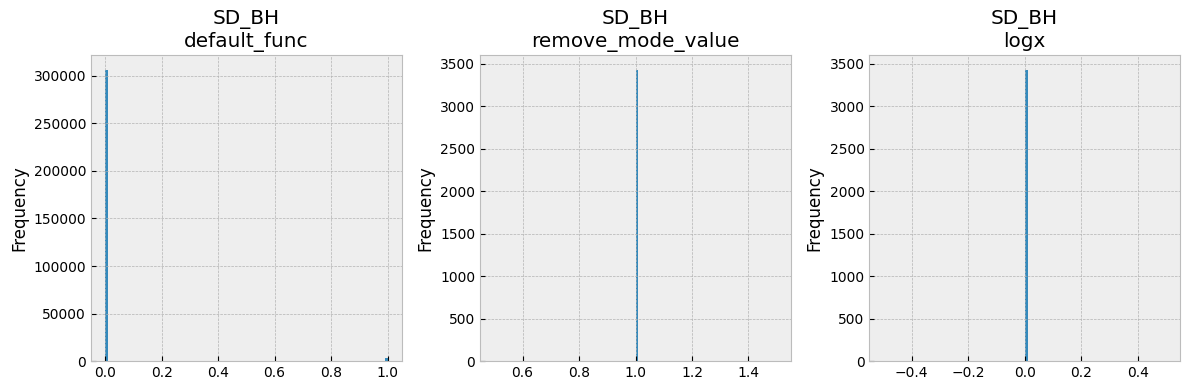

,default_func,remove_mode_value,logx
count,319902.000,67125.000,67125.000
count_pct_chg,100.000,-79.017,-79.017
mean,0.210,1.000,0.000
mean_pct_chg,100.000,376.577,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


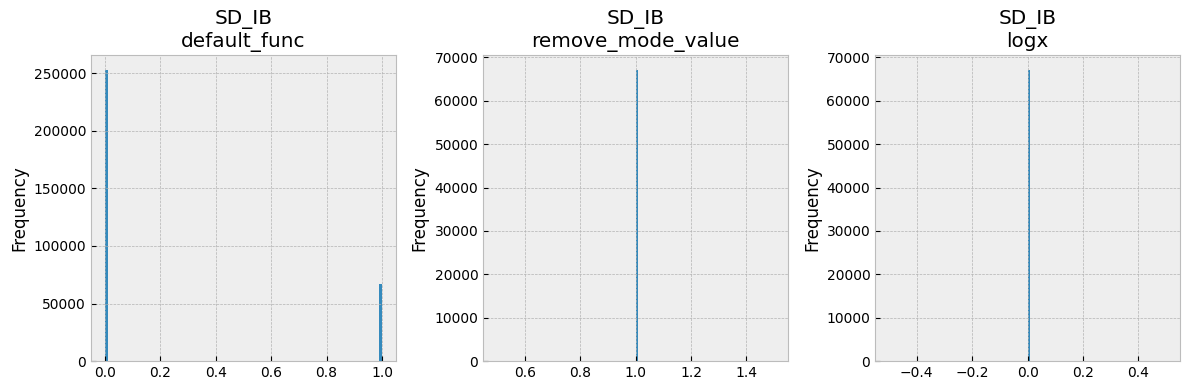

,default_func,remove_mode_value,logx
count,319902.000,55960.000,55960.000
count_pct_chg,100.000,-82.507,-82.507
mean,0.175,1.000,0.000
mean_pct_chg,100.000,471.662,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


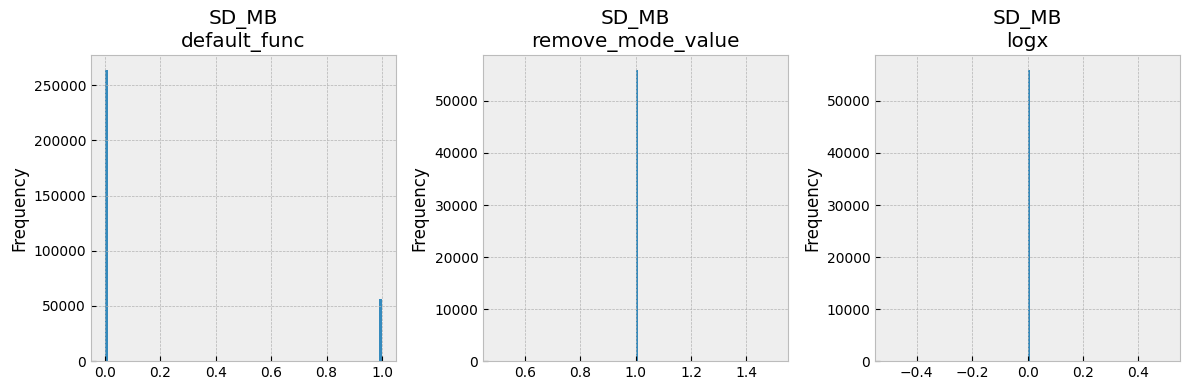

,default_func,remove_mode_value,logx
count,309610.000,93857.000,93857.000
count_pct_chg,100.000,-69.685,-69.685
mean,0.303,1.000,0.000
mean_pct_chg,100.000,229.874,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


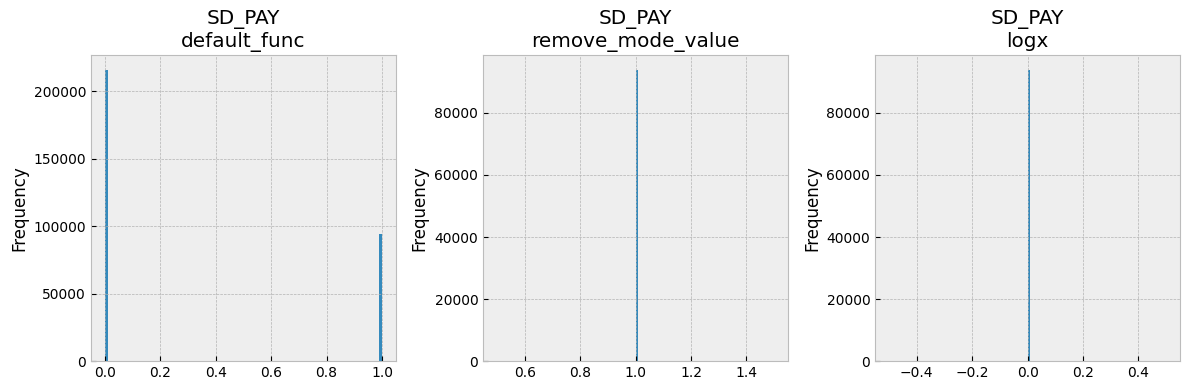

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,319902.000,61373.000,61373.000
count_pct_chg,100.000,-80.815,-80.815
mean,0.808,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


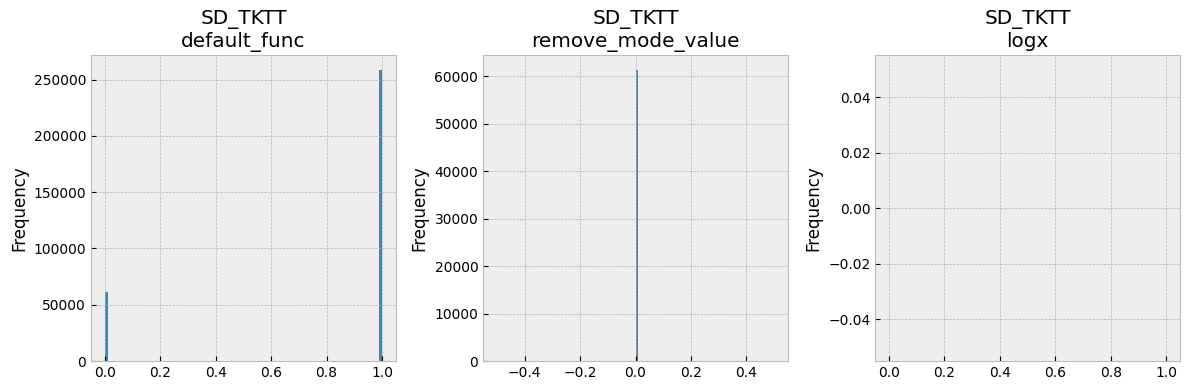

,default_func,remove_mode_value,logx
count,319902.000,28150.000,28150.000
count_pct_chg,100.000,-91.200,-91.200
mean,0.088,1.000,0.000
mean_pct_chg,100.000,1036.419,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


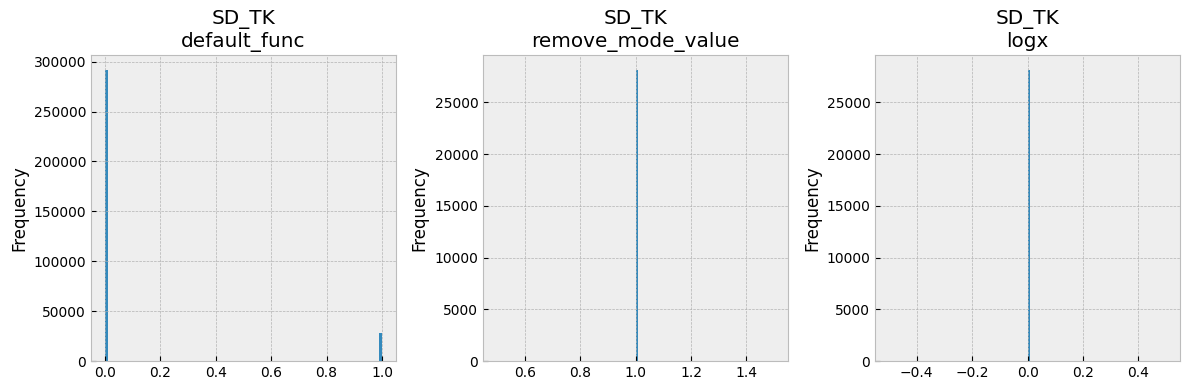

,default_func,remove_mode_value,logx
count,319902.000,8645.000,8645.000
count_pct_chg,100.000,-97.298,-97.298
mean,0.027,1.000,0.000
mean_pct_chg,100.000,3600.428,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


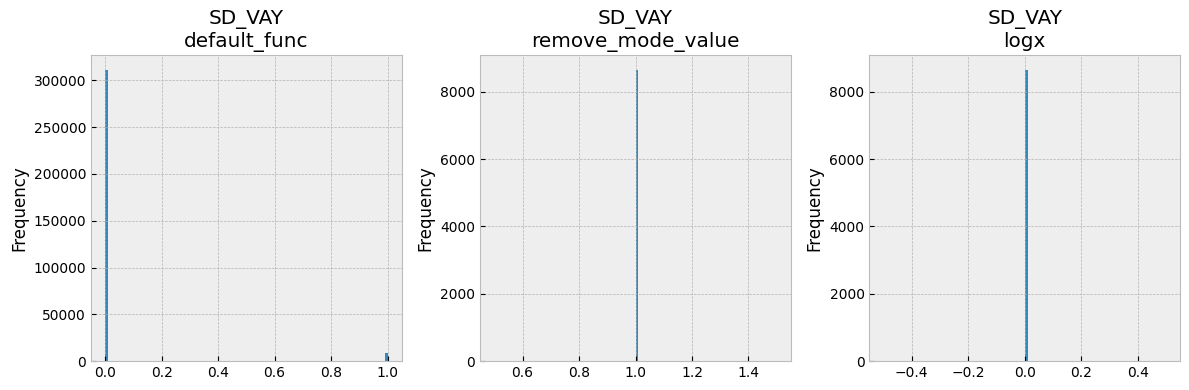

,default_func,remove_mode_value,logx
count,10292.000,210.000,210.000
count_pct_chg,100.000,-97.960,-97.960
mean,0.020,1.000,0.000
mean_pct_chg,100.000,4800.952,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


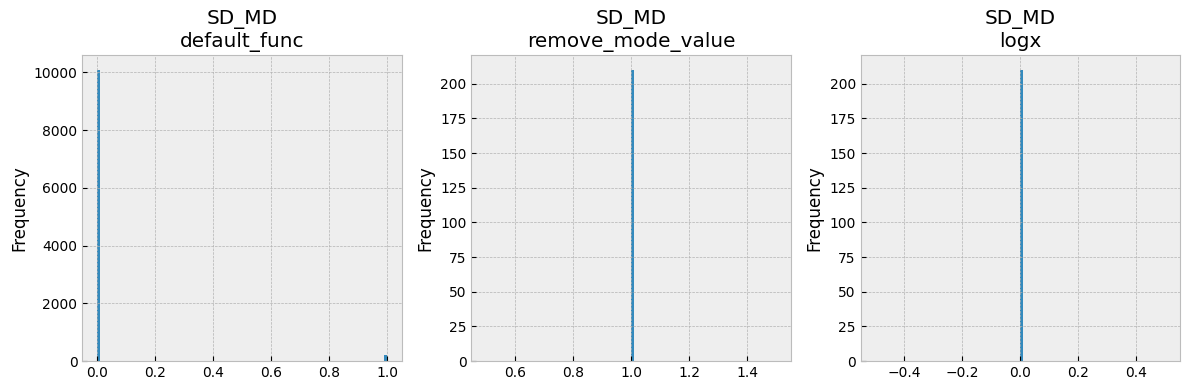

,default_func,remove_mode_value,logx
count,10292.000,18.000,18.000
count_pct_chg,100.000,-99.825,-99.825
mean,0.002,1.000,0.000
mean_pct_chg,100.000,57077.778,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


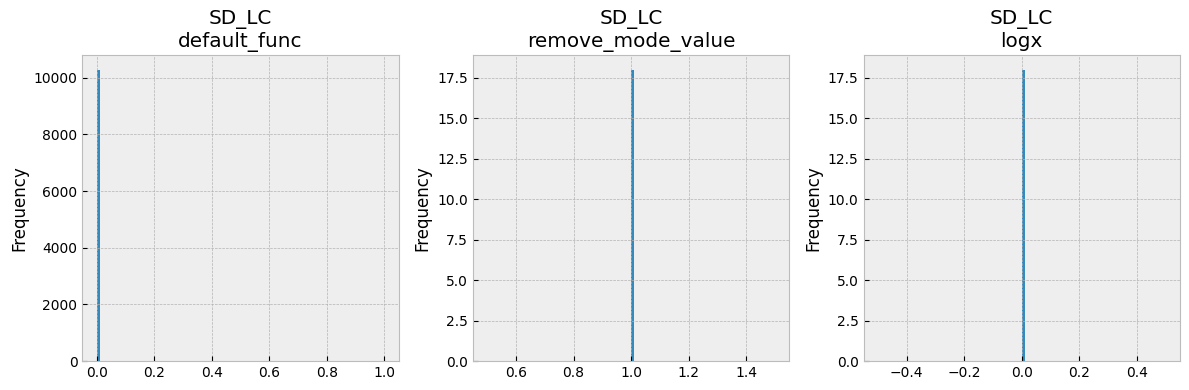

,default_func,remove_mode_value,logx
count,10292.000,217.000,217.000
count_pct_chg,100.000,-97.892,-97.892
mean,0.021,1.000,0.000
mean_pct_chg,100.000,4642.857,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


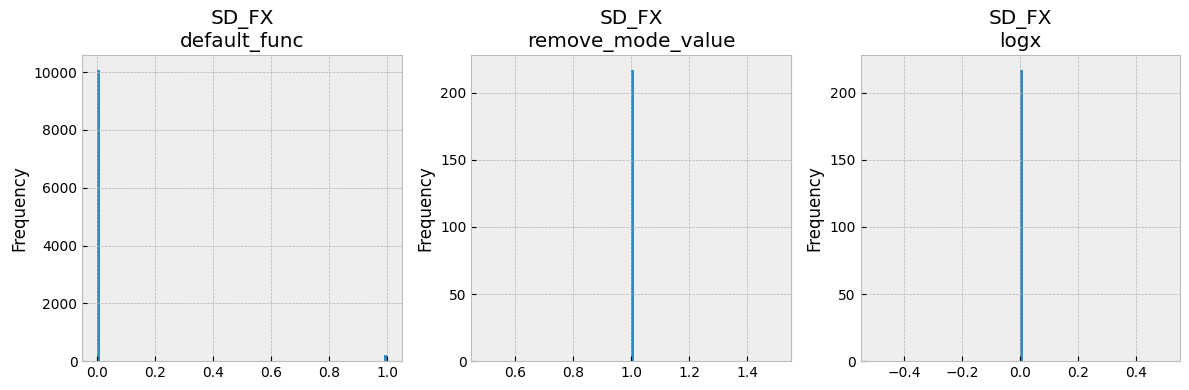

,default_func,remove_mode_value,logx
count,10292.000,204.000,204.000
count_pct_chg,100.000,-98.018,-98.018
mean,0.020,1.000,0.000
mean_pct_chg,100.000,4945.098,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


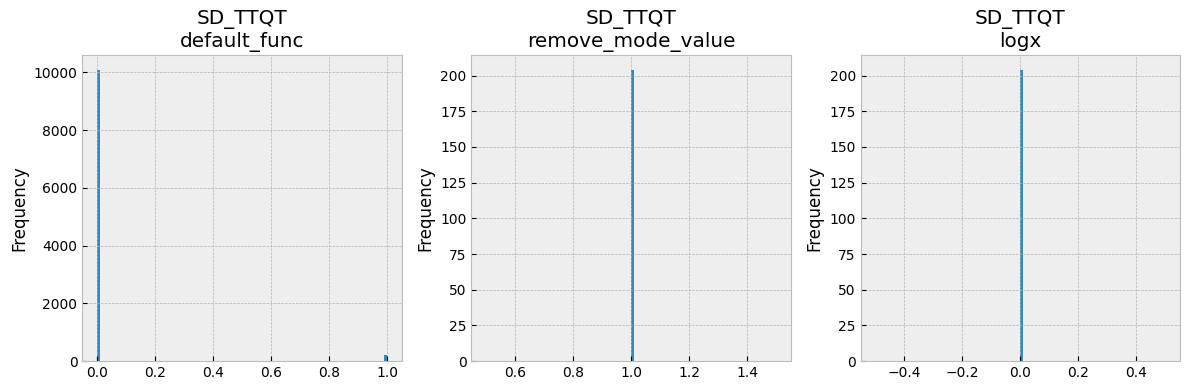

,default_func,remove_mode_value,logx
count,319902.000,23459.000,23459.000
count_pct_chg,100.000,-92.667,-92.667
mean,0.073,1.000,0.000
mean_pct_chg,100.000,1263.664,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


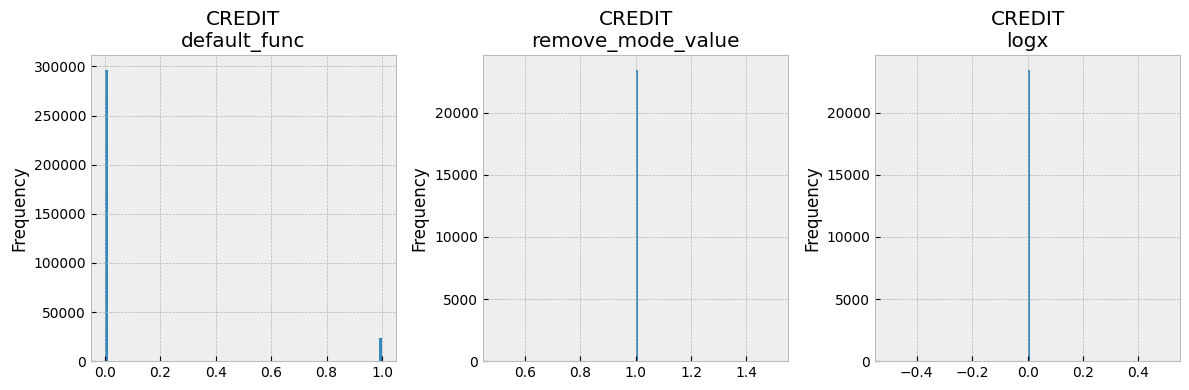

,default_func,remove_mode_value,logx
count,309610.000,2597.000,2597.000
count_pct_chg,100.000,-99.161,-99.161
mean,0.008,1.000,0.000
mean_pct_chg,100.000,11821.833,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


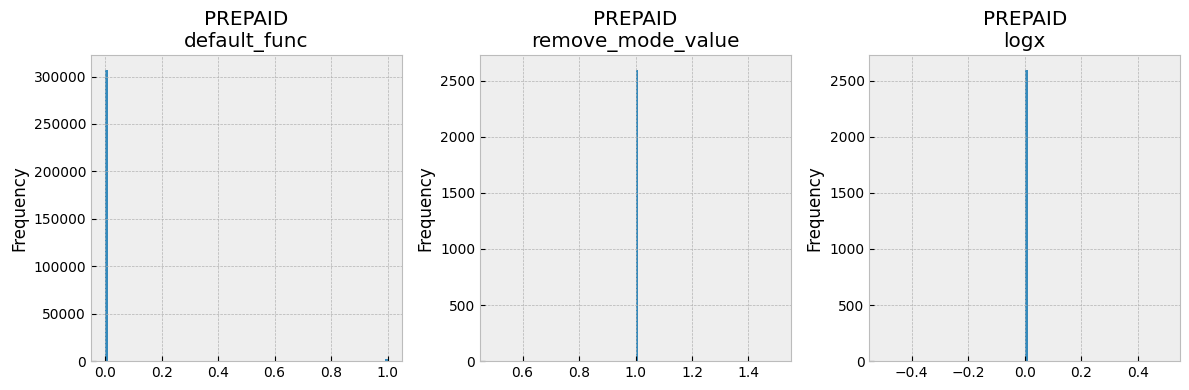

,default_func,remove_mode_value,logx
count,319902.000,23866.000,23866.000
count_pct_chg,100.000,-92.540,-92.540
mean,0.075,1.000,0.000
mean_pct_chg,100.000,1240.409,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


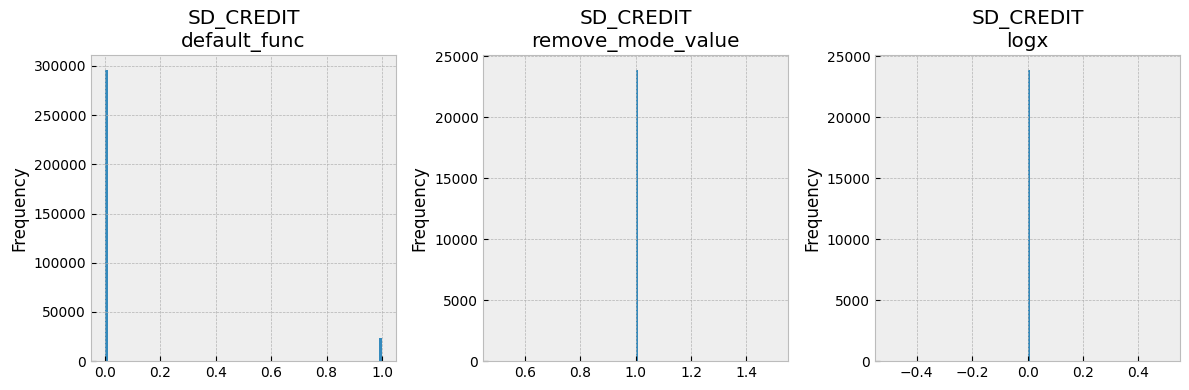

,default_func,remove_mode_value,logx
count,309610.000,2597.000,2597.000
count_pct_chg,100.000,-99.161,-99.161
mean,0.008,1.000,0.000
mean_pct_chg,100.000,11821.833,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


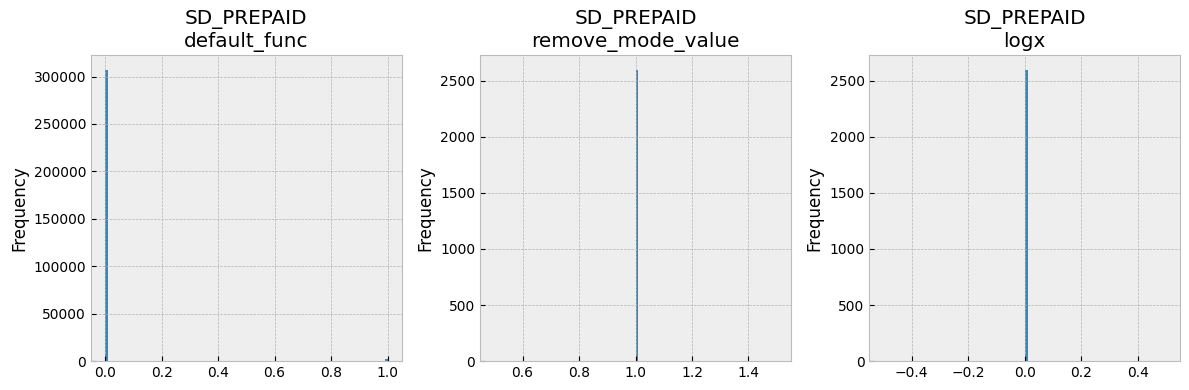

,default_func,remove_mode_value,logx
count,10292.000,83.000,83.000
count_pct_chg,100.000,-99.194,-99.194
mean,0.008,1.000,0.000
mean_pct_chg,100.000,12300.000,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


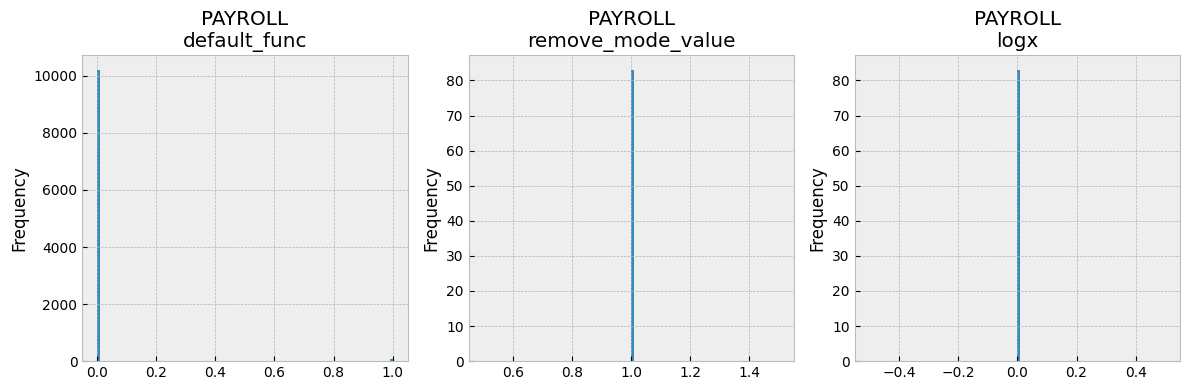

,default_func,remove_mode_value,logx
count,10292.000,83.000,83.000
count_pct_chg,100.000,-99.194,-99.194
mean,0.008,1.000,0.000
mean_pct_chg,100.000,12300.000,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


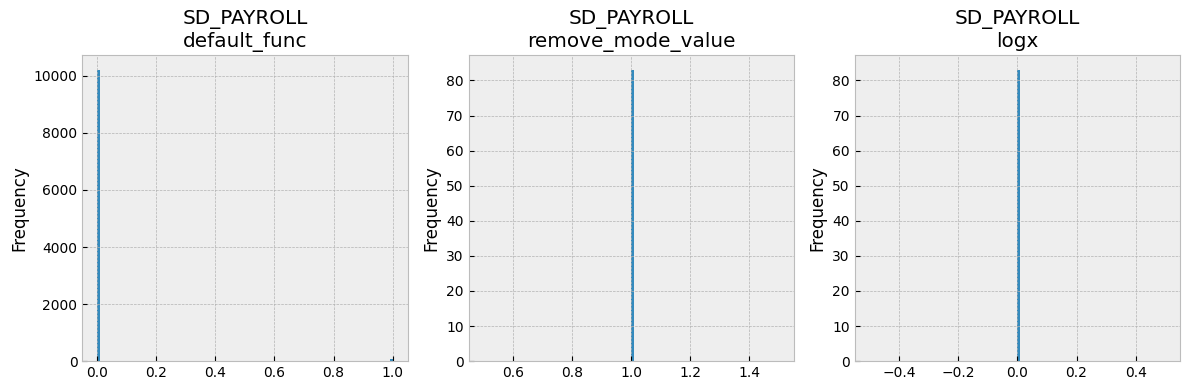

,default_func,remove_mode_value,logx
count,494820.000,28472.000,28472.000
count_pct_chg,100.000,-94.246,-94.246
mean,0.058,1.000,0.000
mean_pct_chg,100.000,1637.918,-100.000
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,1.000,1.000,0.000
max_pct_chg,100.000,0.000,-100.000


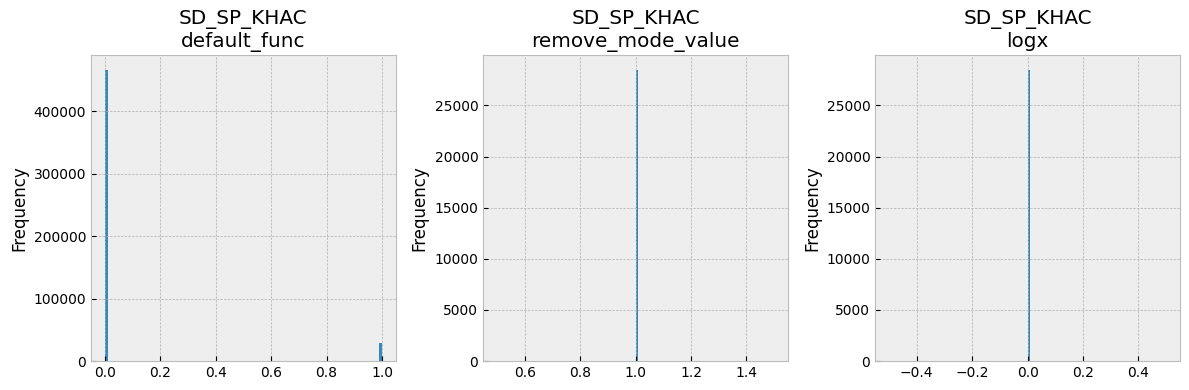

,default_func,remove_mode_value,logx
count,494820.000,12730.000,12730.000
count_pct_chg,100.000,-97.427,-97.427
mean,20831155.348,809715026.668,17.004
mean_pct_chg,100.000,3787.038,-100.000
median,0.000,88374723.500,18.297
median_pct_chg,100.000,inf,inf
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,673058324710.000,673058324710.000,27.235
max_pct_chg,100.000,0.000,-100.000


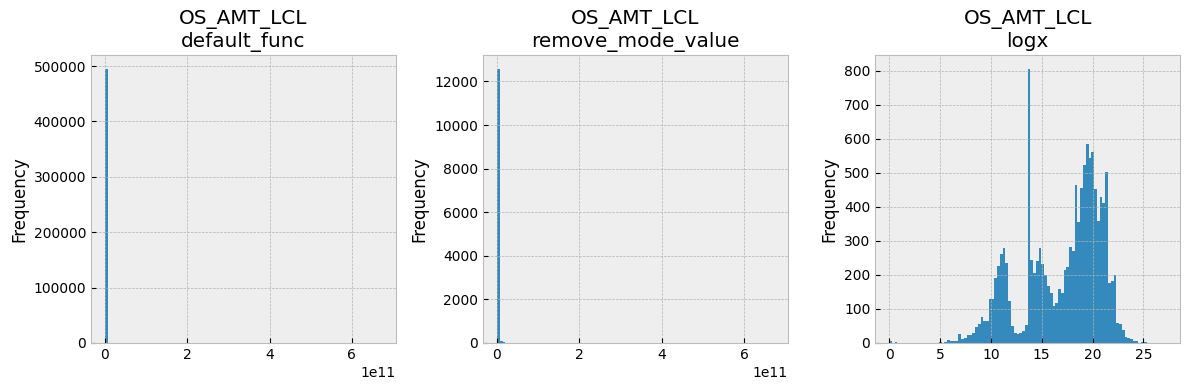

,default_func,remove_mode_value,logx
count,494820.000,250188.000,250188.000
count_pct_chg,100.000,-49.439,-49.439
mean,29638229.194,58618273.339,11.874
mean_pct_chg,100.000,97.779,-100.000
median,140.000,58628.500,10.979
median_pct_chg,100.000,41777.500,-92.158
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,192049236115.000,192049236115.000,25.981
max_pct_chg,100.000,0.000,-100.000


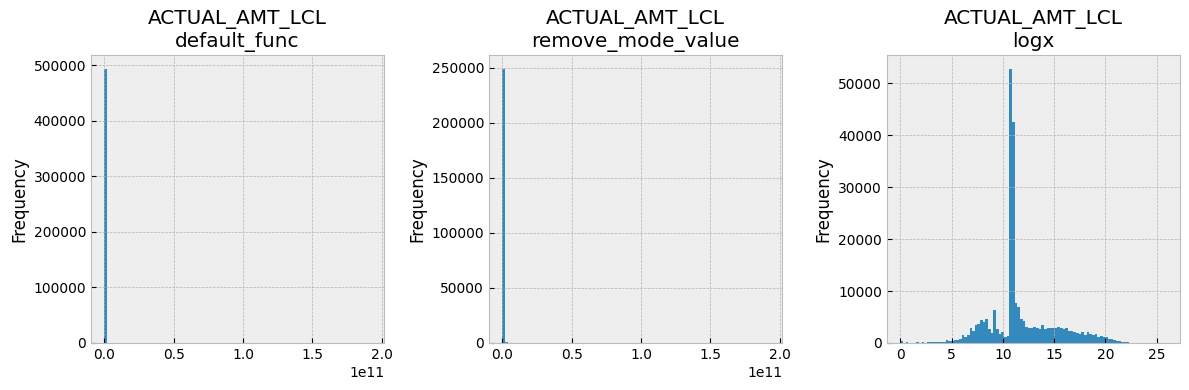

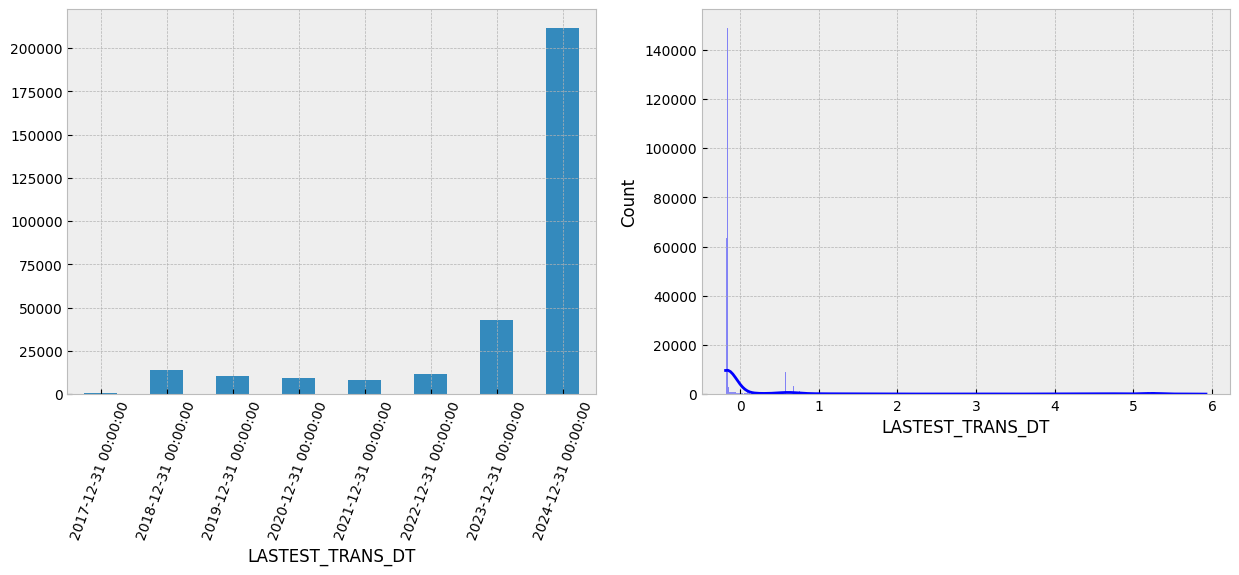

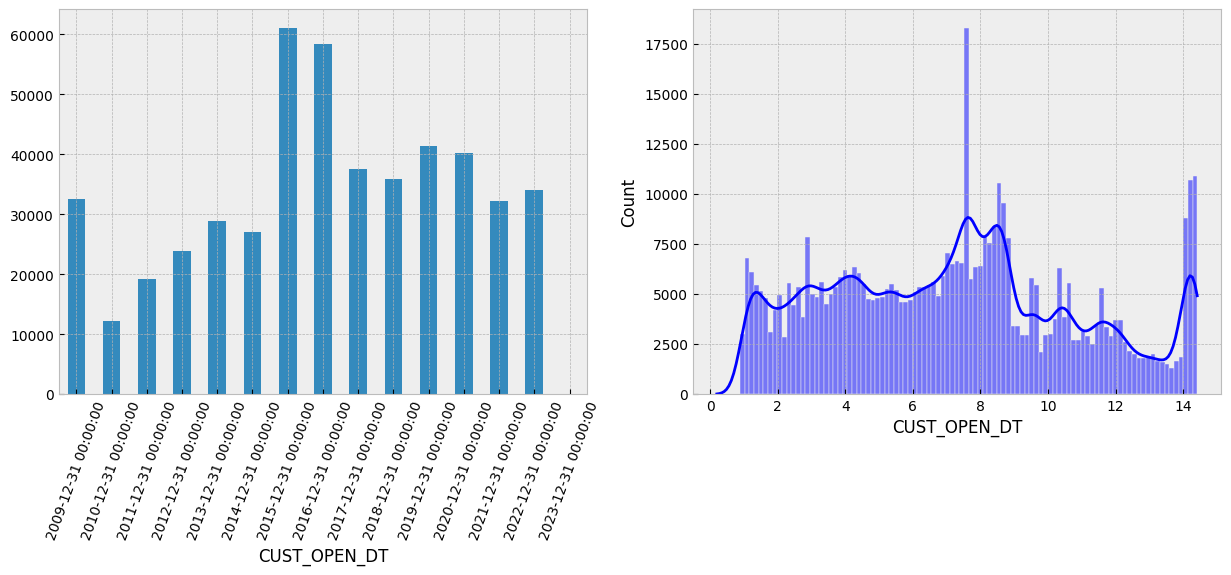

In [64]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [65]:
df.columns, len(df.columns)

(Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
        'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
        'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
        'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
        'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
        'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
        'CUST_OPEN_DT'],
       dtype='object'),
 40)

In [66]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['CUST_TYPE', 'CUST_STATUS', 'BH', 'IB', 'MB', 'PAY', 'TKTT', 'TK',
        'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT', 'SP_KHAC', 'SD_BH', 'SD_IB',
        'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK', 'SD_VAY', 'SD_MD', 'SD_LC',
        'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID', 'SD_CREDIT', 'SD_PREPAID',
        'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC', 'OS_AMT_LCL', 'ACTUAL_AMT_LCL',
        'LASTEST_TRANS_DT', 'CUST_OPEN_DT'],
       dtype='object', name='Column'),
 37)

In [67]:
df.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT'],
      dtype='object')

# DETAIL

In [68]:
df.PROCESS_DT.max()

Timestamp('2024-01-07 00:00:00')

In [69]:
df.CUSTOMER_CDE.nunique()

494820

In [70]:
df

,PROCESS_DT,CUSTOMER_CDE,CUST_TYPE,CUST_STATUS,BH,IB,MB,PAY,TKTT,TK,...,SD_CREDIT,SD_PREPAID,PAYROLL,SD_PAYROLL,SD_SP_KHAC,OS_AMT_LCL,ACTUAL_AMT_LCL,LASTEST_TRANS_DT,REC_CREATE_DT,CUST_OPEN_DT
0,2024-01-07,12030062,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,2022-12-29,2024-01-08 07:24:40,2018-06-29
1,2024-01-07,1203237,CN,DONG BANG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.000,0.000,NaT,2024-01-08 07:24:40,2009-08-08
2,2024-01-07,12032372,CN,HOAT DONG,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,NaN,NaN,0,0.000,0.000,2023-07-17,2024-01-08 07:24:40,2018-06-30
3,2024-01-07,12032399,CN,HOAT DONG,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,61179.000,2024-01-01,2024-01-08 07:24:40,2018-06-30
4,2024-01-07,12032426,CN,DONG BANG,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,NaN,NaN,1,0.000,0.000,2019-01-02,2024-01-08 07:24:40,2018-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494815,2024-01-07,16100962,CN,NGU DONG,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,0.000,NaT,2024-01-08 07:24:40,2021-09-26
494816,2024-01-07,16100989,CN,HOAT DONG,0.000,0.000,0.000,1.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,15520414.000,2024-01-06,2024-01-08 07:24:40,2021-09-26
494817,2024-01-07,1610101,DN,DONG BANG,NaN,0.000,0.000,NaN,0.000,0.000,...,0.000,NaN,0.000,0.000,0,0.000,0.000,NaT,2024-01-08 07:24:40,NaT
494818,2024-01-07,16101937,CN,HOAT DONG,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,NaN,0,0.000,55976.000,2024-01-01,2024-01-08 07:24:40,2021-09-27


In [71]:
df.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT'],
      dtype='object')

<Axes: ylabel='CUST_TYPE'>

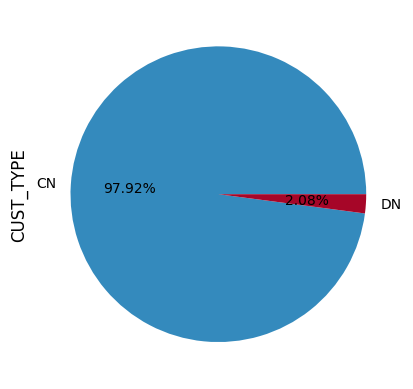

In [72]:
df.CUST_TYPE.value_counts(normalize=True).plot(kind='pie',autopct='%.2f%%')

In [73]:
df1 = df[df['CUST_TYPE']=='CN']

In [74]:
PROD = 'MB'
value_name = 'perc'

In [75]:
df1 = df1.fillna('NA')
# df1 = df1.fillna(0)

In [76]:
df2 = df1[PROD].value_counts(dropna=False)

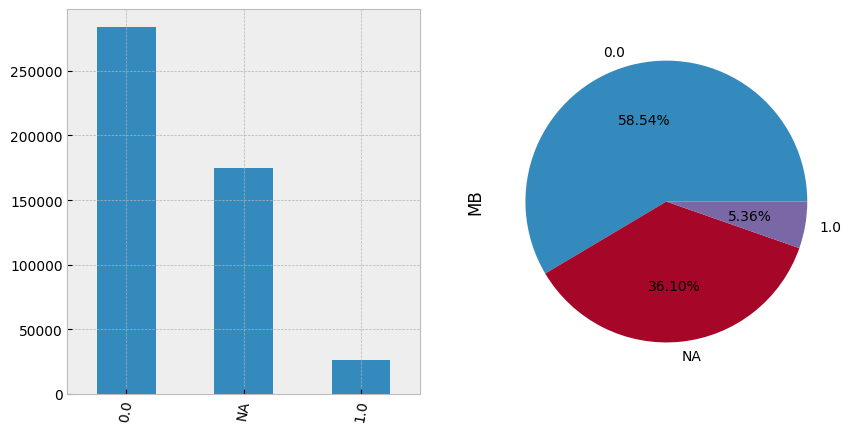

In [77]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
# display(df2)
df2.plot(kind='bar', rot=80,ax=axs[0])
df2.plot(kind='pie', autopct='%.2f%%',ax=axs[1])
plt.savefig(os.path.join(NAMESPACE.img, f'{PROD}.jpg'), dpi=500)
plt.show()

In [78]:
df2 = df1.groupby('CUST_STATUS')[PROD].value_counts(dropna=False, normalize=False).to_frame(name=value_name).reset_index()

In [79]:
df2[value_name] = df2[value_name] / df2[value_name].sum()

In [81]:
# sns.barplot(df2[df2[PROD].isin(['NA',0,1])],x=PROD, y=value_name,hue='CUST_STATUS')
# plt.title('Ti le phan bo')